# Global indicator project - Phoenix, Arizona
## UrbanAccess with gtfs and osm

This notebook provides a brief overview of the main functionality of UrbanAccess (from UrbanSim) with examples using Phoenix GTFS data and OpenStreetMap (OSM) pedestrian network data to create an integrated transit and pedestrian network for use in Pandana network accessibility queries. Current module runs in python 2

**UrbanAccess on UDST:**  https://github.com/UDST/urbanaccess

**UrbanAccess documentation:**  https://udst.github.io/urbanaccess/index.html

**UrbanAccess example:** https://github.com/UDST/urbanaccess/blob/master/demo/simple_example.ipynb

**UrbanAccess citation:**  

`Samuel D. Blanchard and Paul Waddell, 2017, "UrbanAccess: Generalized Methodology for Measuring Regional Accessibility with an Integrated Pedestrian and Transit Network" Transportation Research Record: Journal of the Transportation Research Board, 2653: 35–44.` https://journals.sagepub.com/doi/pdf/10.3141/2653-05

`Samuel D. Blanchard and Paul Waddell, 2017, Assessment of Regional Transit Accessibility in the San Francisco Bay Area of California with UrbanAccess` https://journals.sagepub.com/doi/pdf/10.3141/2654-06



## Installation:

For UrbanAccess installation instructions see: https://udst.github.io/urbanaccess/installation.html
        
This notebook contains optional Pandana examples which require the installation of Pandana, for instructions see here: http://udst.github.io/pandana/installation.html

## Using UrbanAccess as source for:
- The settings object
- The feeds object and searching for GTFS feeds
- Downloading GTFS data
- Loading GTFS data into a UrbanAccess transit data object
- Creating a transit network
- Downloading OSM data
- Creating a pedestrian network
- Creating an integrated transit and pedestrian network
- Visualizing the network
- Using a UrbanAccess network with Pandana

In [7]:
import pandas as pd
import pandana as pdna
import geopandas as gpd
import os
import time
import networkx as nx
import osmnx as ox
import numpy as np

import urbanaccess as ua
from urbanaccess.config import settings
from urbanaccess.gtfsfeeds import feeds
from urbanaccess import gtfsfeeds
from urbanaccess.gtfs.gtfsfeeds_dataframe import gtfsfeeds_dfs
from urbanaccess.network import ua_network, load_network

from shapely.geometry import shape,Point, LineString, Polygon
import config

%matplotlib inline

/Users/NGAU/miniconda3/envs/ind_global/lib/python2.7/site-packages/folium/__init__.py:59: UserWarning: This version of folium is the last to support Python 2. Transition to Python 3 to be able to receive updates and fixes. Check out https://python3statement.org/ for more info.
  UserWarning


In [15]:
# Pandana currently uses depreciated parameters in matplotlib, this hides the warning until its fixed
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [9]:
# configure filenames to save/load POI and network datasets
OSM_folder = config.OSM_data_loc
gtfs_folder = config.gtfs_data_loc

In [11]:
suffix = config.time

place = config.places.values()[0]

# Downloading GTFS data (optional)

GTFS data from transitfeed.com https://transitfeeds.com/p/valley-metro/68

In [3]:
feeds.add_feed(add_dict={'Phx Valley metro': 'https://www.phoenixopendata.com/dataset/3eae9a4a-98b9-40c8-8df7-8c00c1756235/resource/28ccc0a5-49c8-495c-b91f-193de5ce2cb7/download/googletransit.zip'})

Added 1 feeds to gtfs_feeds: {'Phx Valley metro': 'https://www.phoenixopendata.com/dataset/3eae9a4a-98b9-40c8-8df7-8c00c1756235/resource/28ccc0a5-49c8-495c-b91f-193de5ce2cb7/download/googletransit.zip'}


In [4]:
feeds.to_dict()

{'gtfs_feeds': {'Phx Valley metro': 'https://www.phoenixopendata.com/dataset/3eae9a4a-98b9-40c8-8df7-8c00c1756235/resource/28ccc0a5-49c8-495c-b91f-193de5ce2cb7/download/googletransit.zip'}}

In [10]:
#gtfsfeeds.download(data_folder=gtfs_folder, feed_name=None)

# Load GTFS data into an UrbanAccess transit data object

Load the GTFS feeds (currently a series of text files stored on disk) into a combined network of Pandas DataFrames.

- You can specify one feed or multiple feeds that are inside a root folder using the `gtfsfeed_path` parameter. If you want to aggregate multiple transit networks together, all the GTFS feeds you want to aggregate must be inside of a single root folder.
- Turn on `validation` and set a bounding box with the `remove_stops_outsidebbox` parameter turned on to ensure all your GTFS feed data are within a specified area.


In [12]:
validation = True
verbose = True

# get bounding box from study region boundary shapefile
shape_filename ='{studyregion}_buffered{suffix}/{studyregion}_buffered{suffix}.shp'.format(studyregion = place, suffix = suffix)

gdf_shape = gpd.GeoDataFrame.from_file(OSM_folder + '/' + shape_filename)
bbox = (gdf_shape['bbox_west'].astype(float)[0], gdf_shape['bbox_south'].astype(float)[0], gdf_shape['bbox_east'].astype(float)[0], gdf_shape['bbox_north'].astype(float)[0]) #lat-long bounding box for Phx
#Bounding box formatted as a 4 element tuple: (lng_max, lat_min, lng_min, lat_max)

remove_stops_outsidebbox = True
append_definitions = True


In [17]:
#Nload our individual GTFS feeds (currently a series of text files stored on disk) into a combined 
#network of Pandas DataFrames.
loaded_feeds = ua.gtfs.load.gtfsfeed_to_df(gtfsfeed_path=gtfs_folder,
                                           validation=validation,
                                           verbose=verbose,
                                           bbox=bbox,
                                           remove_stops_outsidebbox=remove_stops_outsidebbox,
                                           append_definitions=append_definitions)

GTFS text file encoding check completed. Took 0.12 seconds
GTFS text file header whitespace check completed. Took 3.12 seconds
--------------------------------
Processing GTFS feed: gtfs_phx
The agency.txt or agency_id column was not found. The unique agency id: gtfs_phx was generated using the name of the folder containing the GTFS feed text files.
Unique agency id operation complete. Took 0.19 seconds
Unique GTFS feed id operation complete. Took 0.02 seconds
Records: {}
           stop_id  stop_code                          stop_name  stop_desc  \
16            1014    14968.0            Baseline Rd & Dobson Rd        NaN   
101           1090    13122.0       Broadway Rd & Alma School Rd        NaN   
103           1092    13126.0      Broadway Rd & Country Club Dr        NaN   
105           1094    13125.0                 Broadway Rd & Date        NaN   
106           1095    13118.0            Broadway Rd & Dobson Rd        NaN   
107           1096    13113.0            Broadway

### The transit data object

The output is a global `urbanaccess_gtfs_df` object that can be accessed with the specified variable `loaded_feeds`. This object holds all the individual GTFS feed files aggregated together with each GTFS feed file type in separate Pandas DataFrames to represent all the loaded transit feeds in a metropolitan area. 

In [18]:
loaded_feeds.stops.head()

stop_id  stop_code              stop_name  stop_desc   stop_lat    stop_lon  \
0     100    16619.0      Bell Rd & 44th St        NaN  33.640488 -111.986041   
1    1002    15234.0     Alice Av & 66th Dr        NaN  33.563533 -112.200947   
2   10021    16877.0     3rd St & Taylor St        NaN  33.453085 -112.070037   
3    1003    13532.0   Atlanta Av & 11th Av        NaN  33.400036 -112.085804   
4    1004    14926.0  Baseline Rd & 19th Av        NaN  33.377644 -112.098529   

   zone_id  stop_url  location_type parent_station unique_agency_id  \
0      NaN       NaN              0            NaN         gtfs_phx   
1      NaN       NaN              0            NaN         gtfs_phx   
2      NaN       NaN              0            NaN         gtfs_phx   
3      NaN       NaN              0            NaN         gtfs_phx   
4      NaN       NaN              0            NaN         gtfs_phx   

  unique_feed_id  route_type location_type_desc  
0     gtfs_phx_1         3.0               stop  
1     gtfs_phx_1         3.0               stop  
2     gtfs_phx_1         3.0               stop  
3     gtfs_phx_1         3.0               stop  
4     gtfs_phx_1         3.0               stop

In [19]:
loaded_feeds.stops.unique_agency_id.unique()

array(['gtfs_phx'], dtype=object)

Quickly view the transit stop locations

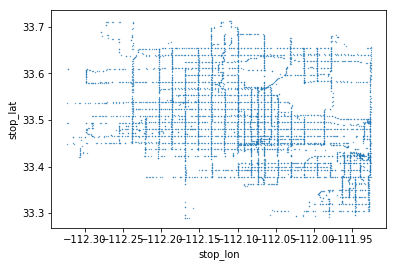

In [20]:
loaded_feeds.stops.plot(kind='scatter', x='stop_lon', y='stop_lat', s=0.1)

In [21]:
loaded_feeds.routes.head()

route_id route_short_name route_long_name  route_desc  route_type route_url  \
0        1                1   Washington St         NaN           3       NaN   
1        3                3    Van Buren St         NaN           3       NaN   
2        7                7          7th St         NaN           3       NaN   
3        8                8         7th Ave         NaN           3       NaN   
4       10               10    Roosevelt St         NaN           3       NaN   

  unique_agency_id unique_feed_id route_type_desc  
0         gtfs_phx     gtfs_phx_1             Bus  
1         gtfs_phx     gtfs_phx_1             Bus  
2         gtfs_phx     gtfs_phx_1             Bus  
3         gtfs_phx     gtfs_phx_1             Bus  
4         gtfs_phx     gtfs_phx_1             Bus

In [22]:
loaded_feeds.stop_times.head()

trip_id arrival_time departure_time stop_id  stop_sequence  pickup_type  \
0  4265517801     06:02:00       06:02:00    9643             10            0   
1  4265517801     06:03:00       06:03:00   30319             11            0   
2  4265517801     06:04:00       06:04:00    7643             12            0   
3  4265517801     06:05:00       06:05:00    2561             13            0   
4  4265517801     06:06:00       06:06:00    2554             14            0   

   drop_off_type  timepoint unique_agency_id unique_feed_id  route_type  \
0              0          1         gtfs_phx     gtfs_phx_1           3   
1              0          0         gtfs_phx     gtfs_phx_1           3   
2              0          0         gtfs_phx     gtfs_phx_1           3   
3              0          0         gtfs_phx     gtfs_phx_1           3   
4              0          0         gtfs_phx     gtfs_phx_1           3   

      pickup_type_desc   drop_off_type_desc     timepoint_desc  \
0  Regularly Scheduled  Regularly Scheduled        Exact times   
1  Regularly Scheduled  Regularly Scheduled  Approximate times   
2  Regularly Scheduled  Regularly Scheduled  Approximate times   
3  Regularly Scheduled  Regularly Scheduled  Approximate times   
4  Regularly Scheduled  Regularly Scheduled  Approximate times   

   departure_time_sec  
0               21720  
1               21780  
2               21840  
3               21900  
4               21960

In [23]:
loaded_feeds.trips.head()

route_id           service_id     trip_id         trip_headsign  \
0     68CM  1901SC-SC-Friday-01  4265517801  Scottsdale Com Collg   
1     68CM  1901SC-SC-Friday-01  4265517865      GR Senior Center   
2     MLHD  1901SC-SC-Friday-01  4265517930            Mustang TC   
3     MLHD  1901SC-SC-Friday-01  4265517964      GR Senior Center   
4     OLDT  1901SC-SC-Friday-01  4265518000      Old Town Trolley   

   direction_id   block_id  shape_id unique_agency_id unique_feed_id  
0             0  1820859.0  68CM0002         gtfs_phx     gtfs_phx_1  
1             1  1820862.0  68CM0001         gtfs_phx     gtfs_phx_1  
2             0  1820861.0  MLHD0002         gtfs_phx     gtfs_phx_1  
3             1  1820859.0  MLHD0001         gtfs_phx     gtfs_phx_1  
4             1  1820870.0  OLDT0001         gtfs_phx     gtfs_phx_1

In [24]:
loaded_feeds.calendar.head()

service_id  monday  tuesday  wednesday  thursday  \
0          TMOT18-TEMPMESA-M-Tu-W-Th-01       1        1          1         1   
1  TMOT18-TEMPMESA-M-Tu-W-Th-01-1111000       1        1          1         1   
2  TMOT18-TEMPMESA-M-Tu-W-Th-01-0010000       0        0          1         0   
3  TMOT18-TEMPMESA-M-Tu-W-Th-01-1101000       1        1          0         1   
4             TMOT18-TEMPMESA-Friday-01       0        0          0         0   

   friday  saturday  sunday  start_date  end_date unique_agency_id  \
0       0         0       0    20190403  20190418         gtfs_phx   
1       0         0       0    20190403  20190418         gtfs_phx   
2       0         0       0    20190403  20190418         gtfs_phx   
3       0         0       0    20190403  20190418         gtfs_phx   
4       1         0       0    20190405  20190419         gtfs_phx   

  unique_feed_id  
0     gtfs_phx_1  
1     gtfs_phx_1  
2     gtfs_phx_1  
3     gtfs_phx_1  
4     gtfs_phx_1

# Create a transit network

Now that we have loaded and standardized our GTFS data, let's create a travel time weighted graph from the GTFS feeds we have loaded.

Create a network for weekday `monday` service between 7 am and 10 am (`['07:00:00', '10:00:00']`) to represent travel times during the AM Peak period.

Assumptions: We are using the service ids in the `calendar` file to subset the day of week, however if your feed uses the `calendar_dates` file and not the `calendar` file then you can use the `calendar_dates_lookup` parameter.

In [25]:
ua.gtfs.network.create_transit_net(gtfsfeeds_dfs=loaded_feeds,
                                   day='monday',
                                   timerange=['07:00:00', '10:00:00'],
                                   calendar_dates_lookup=None)

Using calendar to extract service_ids to select trips.
26 service_ids were extracted from calendar
15,882 trip(s) 29.36 percent of 54,102 total trip records were found in calendar for GTFS feed(s): ['gtfs phx']
NOTE: If you expected more trips to have been extracted and your GTFS feed(s) have a calendar_dates file, consider utilizing the calendar_dates_lookup parameter in order to add additional trips based on information inside of calendar_dates. This should only be done if you know the corresponding GTFS feed is using calendar_dates instead of calendar to specify service_ids. When in doubt do not use the calendar_dates_lookup parameter.
15,882 of 54,102 total trips were extracted representing calendar day: monday. Took 0.13 seconds
There are no departure time records missing from trips following monday schedule. There are no records to interpolate.
Difference between stop times has been successfully calculated. Took 5.77 seconds
Stop times from 07:00:00 to 10:00:00 successfully selec

### The UrbanAccess network object

The output is a global `urbanaccess_network` object. This object holds the resulting graph comprised of nodes and edges for the processed GTFS network data for services operating at the day and time you specified inside of `transit_edges` and `transit_nodes`.

Let's set the global network object to a variable called `urbanaccess_net` that we can then inspect:

In [27]:
urbanaccess_net = ua.network.ua_network

In [28]:
urbanaccess_net.transit_edges.head()

node_id_from     node_id_to unique_agency_id       unique_trip_id  \
0  9008_gtfs_phx  9016_gtfs_phx         gtfs_phx  4191618014_gtfs_phx   
1  9016_gtfs_phx  9027_gtfs_phx         gtfs_phx  4191618014_gtfs_phx   
2  9027_gtfs_phx  9025_gtfs_phx         gtfs_phx  4191618014_gtfs_phx   
3  9020_gtfs_phx  9008_gtfs_phx         gtfs_phx  4191618015_gtfs_phx   
4  9008_gtfs_phx  9016_gtfs_phx         gtfs_phx  4191618015_gtfs_phx   

     weight  sequence                     id  route_type unique_route_id  \
0  3.750000         1  4191618014_gtfs_phx_1           0   LTRL_gtfs_phx   
1  2.000000         2  4191618014_gtfs_phx_2           0   LTRL_gtfs_phx   
2  2.500000         3  4191618014_gtfs_phx_3           0   LTRL_gtfs_phx   
3  1.666667         1  4191618015_gtfs_phx_1           0   LTRL_gtfs_phx   
4  3.750000         2  4191618015_gtfs_phx_2           0   LTRL_gtfs_phx   

  net_type  
0  transit  
1  transit  
2  transit  
3  transit  
4  transit

In [29]:
urbanaccess_net.transit_nodes.head()

x          y unique_agency_id  route_type stop_id  \
node_id                                                                      
100_gtfs_phx   -111.986041  33.640488         gtfs_phx         3.0     100   
1002_gtfs_phx  -112.200947  33.563533         gtfs_phx         3.0    1002   
10021_gtfs_phx -112.070037  33.453085         gtfs_phx         3.0   10021   
1003_gtfs_phx  -112.085804  33.400036         gtfs_phx         3.0    1003   
1004_gtfs_phx  -112.098529  33.377644         gtfs_phx         3.0    1004   

                            stop_name parent_station  stop_code  zone_id  \
node_id                                                                    
100_gtfs_phx        Bell Rd & 44th St            NaN    16619.0      NaN   
1002_gtfs_phx      Alice Av & 66th Dr            NaN    15234.0      NaN   
10021_gtfs_phx     3rd St & Taylor St            NaN    16877.0      NaN   
1003_gtfs_phx    Atlanta Av & 11th Av            NaN    13532.0      NaN   
1004_gtfs_phx   Baseline Rd & 19th Av            NaN    14926.0      NaN   

                location_type net_type  
node_id                                 
100_gtfs_phx                0  transit  
1002_gtfs_phx               0  transit  
10021_gtfs_phx              0  transit  
1003_gtfs_phx               0  transit  
1004_gtfs_phx               0  transit

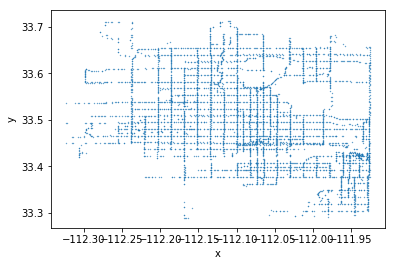

In [30]:
urbanaccess_net.transit_nodes.plot(kind='scatter', x='x', y='y', s=0.1)

## create OSM walk network via UrbanAccess

In [31]:
nodes, edges = ua.osm.load.ua_network_from_bbox(bbox=bbox, remove_lcn=True)

/Users/NGAU/miniconda3/envs/ind_global/lib/python2.7/site-packages/osmnet/load.py:390: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  y_points = np.linspace(lat_min, lat_max, num=max(y_num, min_num))


Requesting network data within bounding box from Overpass API in 4 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](33.29037390,-112.12548510,33.60620459,-111.92550627);>;);out;'}"
Downloaded 49,206.0KB from www.overpass-api.de in 3.14 seconds
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](33.29037390,-112.32402890,33.60454676,-112.12143631);>;);out;'}"
Downloaded 27,663.7KB from www.overpass-api.de in 3.41 seconds
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedes

/Users/NGAU/miniconda3/envs/ind_global/lib/python2.7/site-packages/pandana/network.py:82: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  nodes_df.astype('double').as_matrix(),


573 out of 214,089 nodes (0.27 percent of total) were identified as having low connectivity and have been removed.
Completed OSM data download and graph node and edge table creation in 1,856.31 seconds


In [32]:
edges.sort_values(by='from').head()

access bridge    distance      from  hgv      highway  \
41190548 1515772833    NaN    NaN  129.887053  41190548  NaN  residential   
         1515772851    NaN    NaN   50.890285  41190548  NaN  residential   
         1515772854    NaN    NaN   17.433518  41190548  NaN  residential   
         1515772892    NaN    NaN  120.417829  41190548  NaN  residential   
41190554 41723811      NaN    NaN   60.263260  41190554  NaN  residential   

                    lanes maxspeed                     name oneway  ref  \
41190548 1515772833   NaN      NaN  Encanto Drive Southeast    NaN  NaN   
         1515772851     2   25 mph    West Monte Vista Road     no  NaN   
         1515772854     2   25 mph    West Monte Vista Road     no  NaN   
         1515772892     2   25 mph  Encanto Drive Northeast     no  NaN   
41190554 41723811       2   25 mph         North 9th Avenue     no  NaN   

                    service          to tunnel  
41190548 1515772833     NaN  1515772833    NaN  
         1515772851     NaN  1515772851    NaN  
         1515772854     NaN  1515772854    NaN  
         1515772892     NaN  1515772892    NaN  
41190554 41723811       NaN    41723811    NaN

create a travel time weighted graph from the pedestrian network we have loaded and add it to our existing UrbanAccess network object. We will assume a pedestrian travels on average at 3 mph.

In [34]:
ua.osm.network.create_osm_net(osm_edges=edges, osm_nodes=nodes, travel_speed_mph=3)

Created OSM network with travel time impedance using a travel speed of 3 MPH. Took 0.02 seconds


Download OpenStreetMap (OSM) pedestrian street network data to produce a graph network of nodes and edges for Phoenix. 

In [ ]:
#define travel speed for pedestrain network
travel_speed_mph = 3
G_filename = '{studyregion}_walk{suffix}.graphml'.format(studyregion = place, suffix = config.time)


if os.path.isfile(OSM_folder + "/" + G_filename):
    # if a street network file already exists, load the network graph
    G_osm_walk = ox.load_graphml(G_filename, folder = OSM_folder)
    # get gdf nodes and edges
    gdf_osm_walk_nodes = ox.graph_to_gdfs(G_osm_walk, nodes=True, edges=False)
    gdf_osm_walk_edges = ox.graph_to_gdfs(G_osm_walk, nodes=False, edges=True)
    gdf_osm_walk_edges = gdf_osm_walk_edges.rename(columns={'length': 'distance'})
    #rename length in edge dateframe to distance to accomodate the ua network function
    
    # create a travel time weighted graph from the pedestrian network
    ua.osm.network.create_osm_net(osm_edges=gdf_osm_walk_edges, osm_nodes=gdf_osm_walk_nodes, travel_speed_mph=travel_speed_mph)

    method = 'loaded from graphml'
else:
    # otherwise, query the OSM API for the street network 
    G_osm_walk = ox.graph_from_place(place, network_type= 'walk', retain_all=True, buffer_dist=1e4)
      # get gdf nodes and edges
    gdf_osm_walk_nodes = ox.graph_to_gdfs(G_osm_walk, nodes=True, edges=False)
    gdf_osm_walk_edges = ox.graph_to_gdfs(G_osm_walk, nodes=False, edges=True)
    gdf_osm_walk_edges = gdf_osm_walk_edges.rename(columns={'length': 'distance'})
    #rename length in edge dateframe to distance to accomodate the ua network function
    
    # create a travel time weighted graph from the pedestrian network 
    ua.osm.network.create_osm_net(osm_edges=gdf_osm_walk_edges, osm_nodes=gdf_osm_walk_nodes, travel_speed_mph=travel_speed_mph)

    method = 'downloaded from OSM'


# Create a pedestrian network



The resulting weighted network will be added to your UrbanAccess network object inside `osm_nodes` and `osm_edges`

Let's inspect the results which we can access inside of the existing `urbanaccess_net` variable:

In [35]:
urbanaccess_net.osm_nodes.head()

x          y        id net_type
id                                                
41190548 -112.083528  33.471232  41190548     walk
41190554 -112.084855  33.470254  41190554     walk
41190566 -111.976541  33.387129  41190566     walk
41190568 -111.976576  33.388799  41190568     walk
41190571 -111.976533  33.390691  41190571     walk

In [36]:
urbanaccess_net.osm_edges.head()

access bridge    distance        from  hgv  \
41190548   1515772833      NaN    NaN  129.887053    41190548  NaN   
1515772833 41190548        NaN    NaN  129.887053  1515772833  NaN   
           41190554        NaN    NaN   51.736034  1515772833  NaN   
41190554   1515772833      NaN    NaN   51.736034    41190554  NaN   
41190566   41190568    private    NaN  185.753076    41190566  NaN   

                           highway lanes maxspeed                     name  \
41190548   1515772833  residential   NaN      NaN  Encanto Drive Southeast   
1515772833 41190548    residential   NaN      NaN  Encanto Drive Southeast   
           41190554    residential   NaN      NaN  Encanto Drive Southeast   
41190554   1515772833  residential   NaN      NaN  Encanto Drive Southeast   
41190566   41190568    residential   NaN      NaN      South Apalosa Drive   

                      oneway  ref service          to tunnel    weight  \
41190548   1515772833    NaN  NaN     NaN  1515772833    NaN  1.614165   
1515772833 41190548      NaN  NaN     NaN    41190548    NaN  1.614165   
           41190554      NaN  NaN     NaN    41190554    NaN  0.642947   
41190554   1515772833    NaN  NaN     NaN  1515772833    NaN  0.642947   
41190566   41190568      NaN  NaN     NaN    41190568    NaN  2.308438   

                      net_type  
41190548   1515772833     walk  
1515772833 41190548       walk  
           41190554       walk  
41190554   1515772833     walk  
41190566   41190568       walk

# Create an integrated transit and pedestrian network

Now let's integrate the two networks together. The resulting graph will be added to your existing UrbanAccess network object. After running this step, your network will be ready to be used with Pandana.

The resulting integrated network will be added to your UrbanAccess network object inside `net_nodes` and `net_edges`

In [37]:
ua.network.integrate_network(urbanaccess_network=urbanaccess_net, headways=False)

Loaded UrbanAccess network components comprised of:
     Transit: 5,853 nodes and 98,678 edges;
     OSM: 213,516 nodes and 597,386 edges


/Users/NGAU/miniconda3/envs/ind_global/lib/python2.7/site-packages/urbanaccess/network.py:65: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  kdt = KDTree(df1.as_matrix())
/Users/NGAU/miniconda3/envs/ind_global/lib/python2.7/site-packages/urbanaccess/network.py:383: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  (osm_row['y'], osm_row['x'])).miles


Connector edges between the OSM and transit network nodes successfully completed. Took 4.53 seconds


/Users/NGAU/miniconda3/envs/ind_global/lib/python2.7/site-packages/urbanaccess/network.py:203: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  urbanaccess_network.net_connector_edges], axis=0)


Fixed unicode error in name column
Edge and node tables formatted for Pandana with integer node ids: id_int, to_int, and from_int. Took 6.70 seconds
Network edge and node network integration completed successfully resulting in a total of 219,369 nodes and 707,770 edges:
     Transit: 5,853 nodes 98,678 edges;
     OSM: 213,516 nodes 597,386 edges; and
     OSM/Transit connector: 11,706 edges.


Let's inspect the results which we can access inside of the existing `urbanaccess_net` variable:

In [38]:
urbanaccess_net.net_nodes.head()

id  location_type net_type parent_station  route_type  \
id_int                                                                      
1         100_gtfs_phx            0.0  transit            NaN         3.0   
2        1002_gtfs_phx            0.0  transit            NaN         3.0   
3       10021_gtfs_phx            0.0  transit            NaN         3.0   
4        1003_gtfs_phx            0.0  transit            NaN         3.0   
5        1004_gtfs_phx            0.0  transit            NaN         3.0   

        stop_code stop_id              stop_name unique_agency_id           x  \
id_int                                                                          
1         16619.0     100      Bell Rd & 44th St         gtfs_phx -111.986041   
2         15234.0    1002     Alice Av & 66th Dr         gtfs_phx -112.200947   
3         16877.0   10021     3rd St & Taylor St         gtfs_phx -112.070037   
4         13532.0    1003   Atlanta Av & 11th Av         gtfs_phx -112.085804   
5         14926.0    1004  Baseline Rd & 19th Av         gtfs_phx -112.098529   

                y  zone_id  
id_int                      
1       33.640488      NaN  
2       33.563533      NaN  
3       33.453085      NaN  
4       33.400036      NaN  
5       33.377644      NaN

In [39]:
urbanaccess_net.net_edges.head()

access bridge  distance           from  hgv highway                edge_id  \
0    nan    nan       NaN  9008_gtfs_phx  nan     nan  4191618014_gtfs_phx_1   
1    nan    nan       NaN  9016_gtfs_phx  nan     nan  4191618014_gtfs_phx_2   
2    nan    nan       NaN  9027_gtfs_phx  nan     nan  4191618014_gtfs_phx_3   
3    nan    nan       NaN  9020_gtfs_phx  nan     nan  4191618015_gtfs_phx_1   
4    nan    nan       NaN  9008_gtfs_phx  nan     nan  4191618015_gtfs_phx_2   

  lanes maxspeed name  ... sequence service             to  tunnel  \
0   nan      nan  NaN  ...      1.0     nan  9016_gtfs_phx     nan   
1   nan      nan  NaN  ...      2.0     nan  9027_gtfs_phx     nan   
2   nan      nan  NaN  ...      3.0     nan  9025_gtfs_phx     nan   
3   nan      nan  NaN  ...      1.0     nan  9008_gtfs_phx     nan   
4   nan      nan  NaN  ...      2.0     nan  9016_gtfs_phx     nan   

   unique_agency_id unique_route_id       unique_trip_id    weight from_int  \
0          gtfs_phx   LTRL_gtfs_phx  4191618014_gtfs_phx  3.750000     5472   
1          gtfs_phx   LTRL_gtfs_phx  4191618014_gtfs_phx  2.000000     5479   
2          gtfs_phx   LTRL_gtfs_phx  4191618014_gtfs_phx  2.500000     5488   
3          gtfs_phx   LTRL_gtfs_phx  4191618015_gtfs_phx  1.666667     5483   
4          gtfs_phx   LTRL_gtfs_phx  4191618015_gtfs_phx  3.750000     5472   

  to_int  
0   5479  
1   5488  
2   5486  
3   5472  
4   5479  

[5 rows x 24 columns]

In [40]:
urbanaccess_net.net_edges[urbanaccess_net.net_edges['net_type'] == 'transit'].head()

access bridge  distance           from  hgv highway                edge_id  \
0    nan    nan       NaN  9008_gtfs_phx  nan     nan  4191618014_gtfs_phx_1   
1    nan    nan       NaN  9016_gtfs_phx  nan     nan  4191618014_gtfs_phx_2   
2    nan    nan       NaN  9027_gtfs_phx  nan     nan  4191618014_gtfs_phx_3   
3    nan    nan       NaN  9020_gtfs_phx  nan     nan  4191618015_gtfs_phx_1   
4    nan    nan       NaN  9008_gtfs_phx  nan     nan  4191618015_gtfs_phx_2   

  lanes maxspeed name  ... sequence service             to  tunnel  \
0   nan      nan  NaN  ...      1.0     nan  9016_gtfs_phx     nan   
1   nan      nan  NaN  ...      2.0     nan  9027_gtfs_phx     nan   
2   nan      nan  NaN  ...      3.0     nan  9025_gtfs_phx     nan   
3   nan      nan  NaN  ...      1.0     nan  9008_gtfs_phx     nan   
4   nan      nan  NaN  ...      2.0     nan  9016_gtfs_phx     nan   

   unique_agency_id unique_route_id       unique_trip_id    weight from_int  \
0          gtfs_phx   LTRL_gtfs_phx  4191618014_gtfs_phx  3.750000     5472   
1          gtfs_phx   LTRL_gtfs_phx  4191618014_gtfs_phx  2.000000     5479   
2          gtfs_phx   LTRL_gtfs_phx  4191618014_gtfs_phx  2.500000     5488   
3          gtfs_phx   LTRL_gtfs_phx  4191618015_gtfs_phx  1.666667     5483   
4          gtfs_phx   LTRL_gtfs_phx  4191618015_gtfs_phx  3.750000     5472   

  to_int  
0   5479  
1   5488  
2   5486  
3   5472  
4   5479  

[5 rows x 24 columns]

# Save the network to disk

You can save the final processed integrated network `net_nodes` and `net_edges` to disk inside of a HDF5 file. By default the file will be saved to the directory of this notebook in the folder `data`

In [42]:
ua.network.save_network(urbanaccess_network=urbanaccess_net,
                        filename='gtfs_osm_net.h5', dir=gtfs_folder,
                        overwrite_key = True)

/Users/NGAU/miniconda3/envs/ind_global/lib/python2.7/site-packages/tables/__init__.py:93: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  from .utilsextension import (
/Users/NGAU/miniconda3/envs/ind_global/lib/python2.7/site-packages/tables/file.py:35: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  from . import hdf5extension
/Users/NGAU/miniconda3/envs/ind_global/lib/python2.7/site-packages/tables/link.py:33: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  from . import linkextension
/Users/NGAU/miniconda3/envs/ind_global/lib/python2.7/site-packages/tables/table.py:28: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  from . import tableextension
/Users/NGAU/

New gtfs_osm_net.h5 hdf5 store created in dir: ../data/Transport
edges saved in ../data/Transport/gtfs_osm_net.h5 hdf5 store.
Using existing ../data/Transport/gtfs_osm_net.h5 hdf5 store.
nodes saved in ../data/Transport/gtfs_osm_net.h5 hdf5 store.


# Load saved network from disk

You can load an existing processed integrated network HDF5 file from disk into a UrbanAccess network object.

In [44]:
gtfs_osm_net = ua.network.load_network(dir=gtfs_folder, filename='gtfs_osm_net.h5')

Successfully read store: ../data/Transport/gtfs_osm_net.h5 with the following keys: ['/edges', '/nodes']
Successfully read store: ../data/Transport/gtfs_osm_net.h5 with the following keys: ['/edges', '/nodes']


# Visualize the network

You can visualize the network you just created using basic UrbanAccess plot functions

### Integrated network

Figure created. Took 204.63 seconds


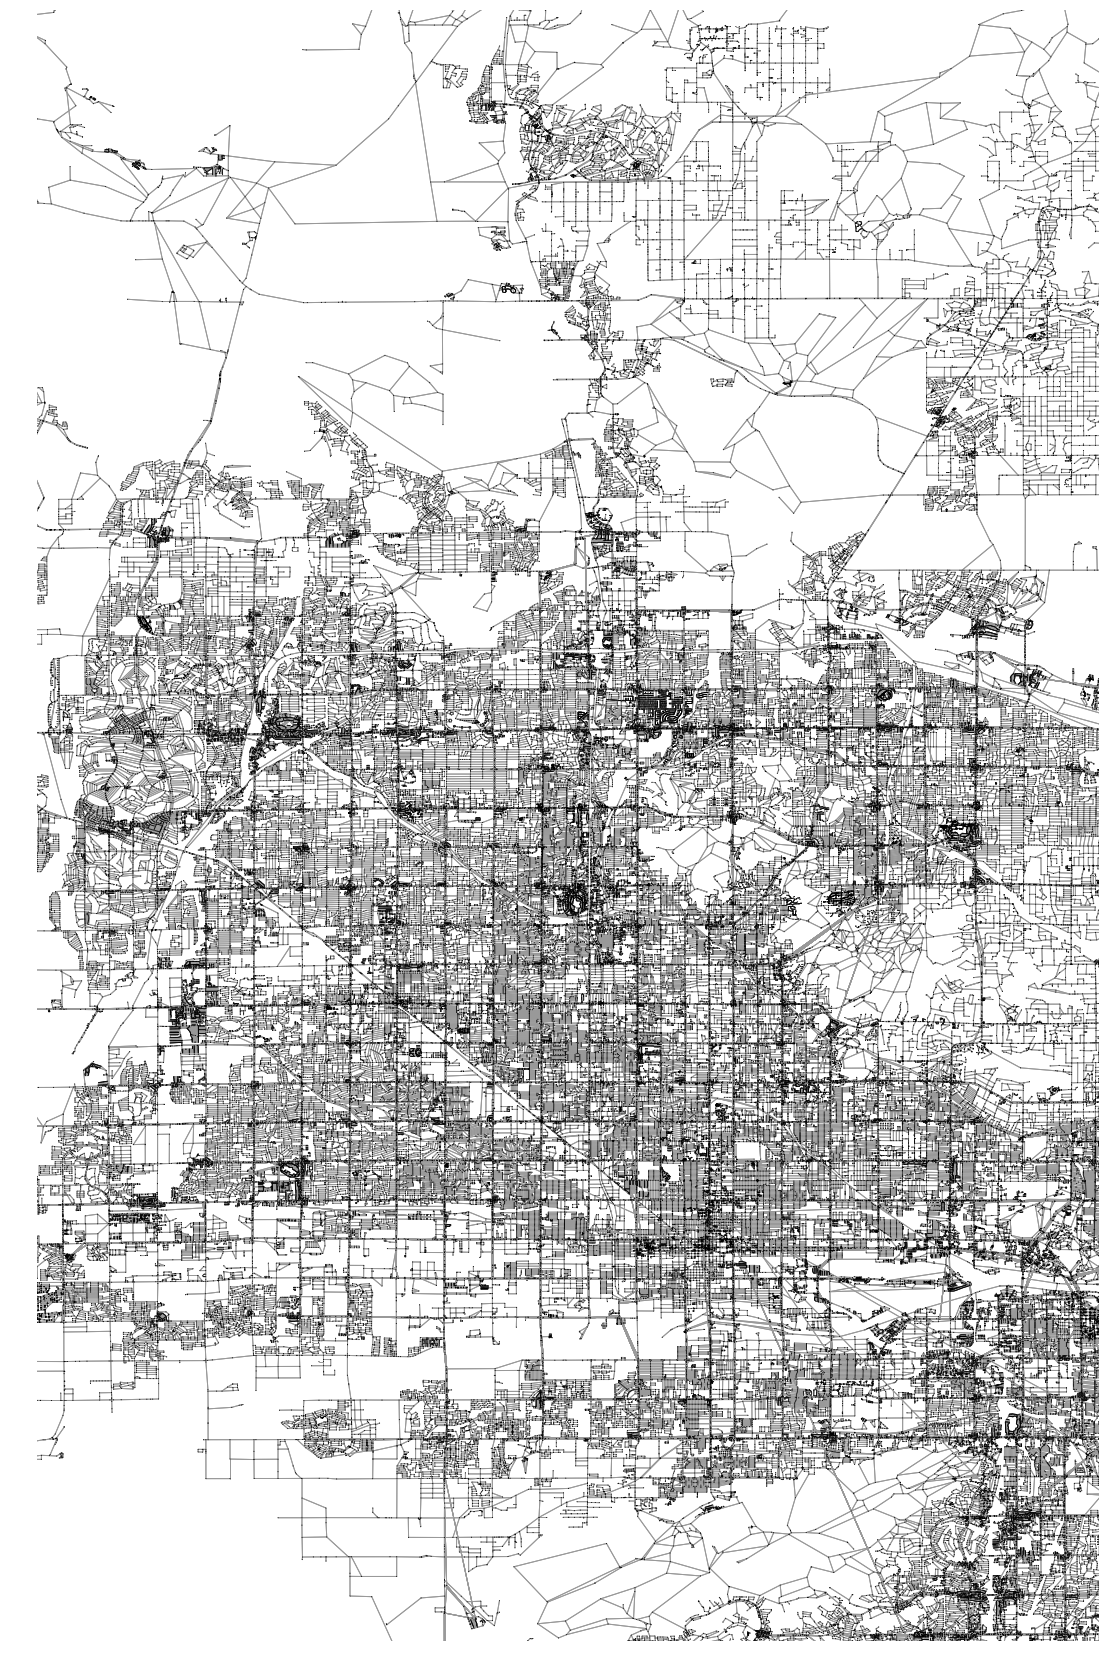

(<Figure size 1370.66x2160 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x22bebcf10>)

In [48]:
ua.plot.plot_net(nodes=gtfs_osm_net.net_nodes,
                 edges=gtfs_osm_net.net_edges,
                 bbox=bbox,
                 fig_height=30, margin=0.02,
                 edge_color='#999999', edge_linewidth=1, edge_alpha=1,
                 node_color='black', node_size=1.1, node_alpha=1, node_edgecolor='none', node_zorder=3, nodes_only=False)

### Integrated network by travel time

Use the `col_colors` function to color edges by travel time. In this case the darker red the higher the travel times.

Figure created. Took 204.27 seconds


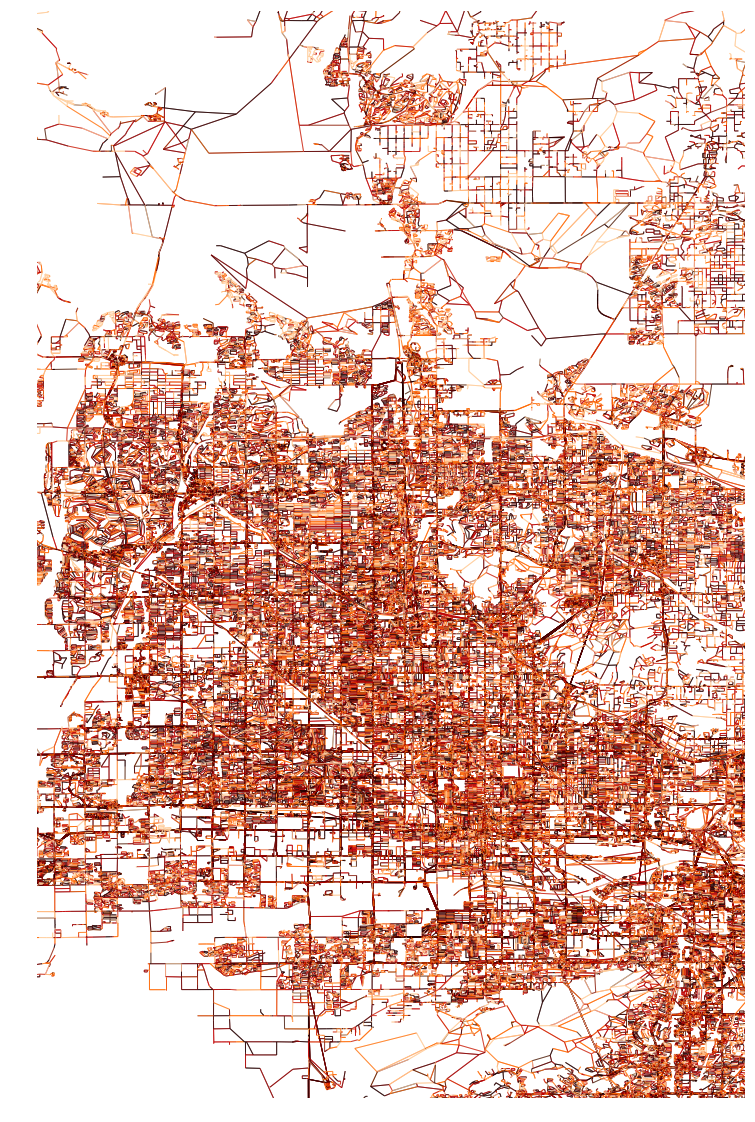

(<Figure size 913.77x1440 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1dac28e10>)

In [50]:
edgecolor = ua.plot.col_colors(df=gtfs_osm_net.net_edges, col='weight', cmap='gist_heat_r', num_bins=5)
ua.plot.plot_net(nodes=gtfs_osm_net.net_nodes,
                 edges=gtfs_osm_net.net_edges,
                 bbox=bbox,
                 fig_height=20, margin=0.02,
                 edge_color=edgecolor, edge_linewidth=1, edge_alpha=0.7,
                 node_color='black', node_size=0, node_alpha=1, node_edgecolor='none', node_zorder=3, nodes_only=False)

### Transit network

You can also slice the network by network type

In [ ]:
ua.plot.plot_net(nodes=gtfs_osm_net.net_nodes,
                 edges=gtfs_osm_net.net_edges[gtfs_osm_net.net_edges['net_type']=='transit'],
                 bbox=None,
                 fig_height=20, margin=0.02,
                 edge_color='#999999', edge_linewidth=1, edge_alpha=1,
                 node_color='black', node_size=0, node_alpha=1, node_edgecolor='none', node_zorder=3, nodes_only=False)

# Using an UrbanAccess network with Pandana

Pandana (Pandas Network Analysis) is a tool to compute network accessibility metrics.

Now that we have an integrated transit and pedestrian network that has been formatted for use with Pandana, we can now use Pandana right away to compute accessibility metrics.

There are a couple of things to remember about UrbanAccess and Pandana:
- UrbanAccess generates by default a one way network. One way means there is an explicit edge for each direction in the edge table. Where applicable, it is important to set any Pandana `two_way` parameters to `False` (they are `True` by default) to indicate that the network is a one way network.
- As of Pandana v0.3.0, `node ids` and `from` and `to` columns in your network must be integer type and not string. UrbanAccess automatically generates both string and integer types so use the `from_int` and `to_int` columns in edges and the index in nodes `id_int`.
- UrbanAccess by default will generate edge weights that represent travel time in units of minutes.

For more on Pandana see the:

**Pandana repo:** https://github.com/UDST/pandana 

**Pandana documentation:** http://udst.github.io/pandana/

## Initialize the Pandana network

Let's initialize our Pandana network object using our transit and pedestrian network we created. Note: the `from_int` and `to_int` as well as the `twoway=False` denoting this is a explicit one way network.

In [ ]:
s_time = time.time()
transit_ped_net = pdna.Network(gtfs_osm_net.net_nodes["x"],
                               gtfs_osm_net.net_nodes["y"],
                               gtfs_osm_net.net_edges["from_int"],
                               gtfs_osm_net.net_edges["to_int"],
                               gtfs_osm_net.net_edges[["weight"]], 
                               twoway=False)
print('Took {:,.2f} seconds'.format(time.time() - s_time))